In [70]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB

sns.set()
%matplotlib inline

In [2]:
## Automate the splitting, training and validation

def split_train_val(data):
    validate = data[data.Year > 2016]
    train = data[data.Year <= 2016]

    train.drop('DATE', axis=1, inplace=True)
    validate.drop('DATE', axis=1, inplace=True)
    
    y_train = train['mission']
    X_train = train.drop('mission', axis=1)

    y_validate = validate['mission']
    X_validate = validate.drop('mission', axis=1)
    
    return X_train, y_train, X_validate, y_validate
    
def test_model(m, X_validate, y_validate):
    print('Validate Score: ',m.score(X_validate, y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate)]
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return True

In [3]:
data = pd.read_csv('sar_weather_df_postengineering.csv')
X_train, y_train, X_validate, y_validate = split_train_val(data)
data.shape

/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(6289, 38)

/home/afederation/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Score:  0.7169016663614722
Validate Score:  0.6634146341463415
ROC AUC:  0.480571984228474


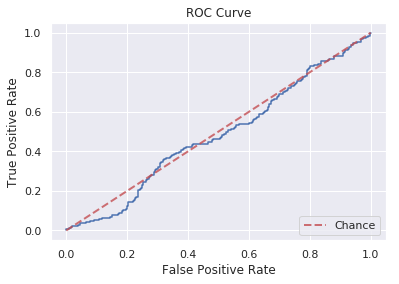

True

In [4]:
# Logistic Regresstion
m = LogisticRegression()
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)

Training Score:  0.7169016663614722
Validate Score:  0.6634146341463415
ROC AUC:  0.519428015771526


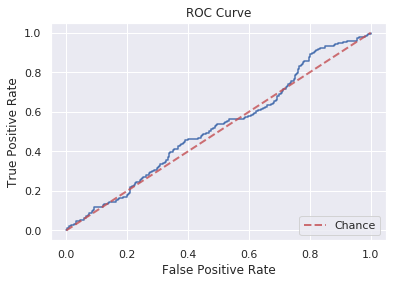

True

In [5]:
# Naive Bayes
m = GaussianNB()
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)

Training Score:  0.7624977110419338
Validate Score:  0.6634146341463415
ROC AUC:  0.5


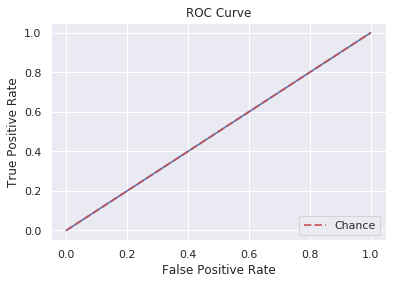

True

In [6]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

m = KNeighborsClassifier(leaf_size=100)
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)
    

Training Score:  0.8802417139718001
Validate Score:  0.675609756097561
ROC AUC:  0.6268382352941176


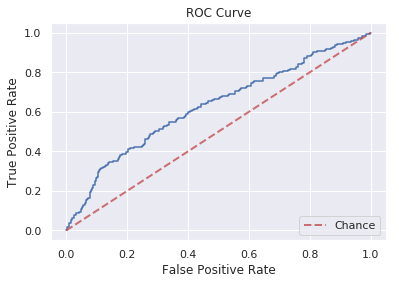

True

In [7]:
# Random Forest
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)
    

Training Score:  0.7328328145028383
Validate Score:  0.675609756097561
ROC AUC:  0.6487139013213981


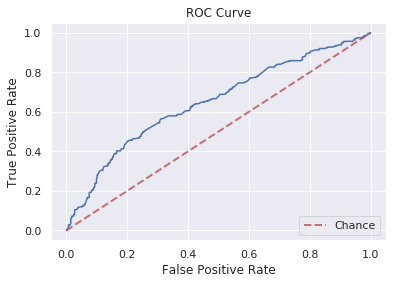

True

In [72]:
# AdaBoost
m = AdaBoostClassifier()
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)


Training Score:  0.7260574986266252
Validate Score:  0.6792682926829269
ROC AUC:  0.6739163736146632


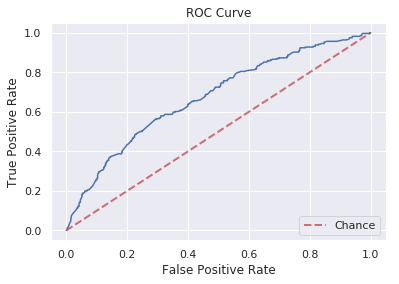

True

In [68]:
from xgboost import XGBClassifier
m = XGBClassifier(booster='gbtree', silent=True, learning_rate=0.1, max_depth=1)
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)
    

In [81]:
# combine into voting classifier

from sklearn.ensemble import VotingClassifier

m1 = XGBClassifier(booster='gbtree', silent=True, learning_rate=0.1, max_depth=1)
m2 = AdaBoostClassifier()
m3 = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)

mv = VotingClassifier(estimators=[('xgb', m1), ('ada', m2), ('rf', m3)], voting='hard')
mv.fit(X_train, y_train)
print('Validate Score: ',mv.score(X_validate, y_validate))


Validate Score:  0.6792682926829269


In [35]:
# Simple neural net, example from book

from keras import models
from keras import layers

m = models.Sequential()
m.add(layers.Dense(10, activation='relu', input_shape=(36,)))
m.add(layers.Dense(10, activation='relu'))
m.add(layers.Dense(1, activation='sigmoid'))

m.compile(optimizer='rmsprop',
          loss='binary_crossentropy',
          metrics=['accuracy']
          )

history = m.fit(X_train, y_train, epochs=3, validation_data=[X_validate, y_validate])

Train on 5461 samples, validate on 820 samples
Epoch 1/3
5461/5461 [==============================] - 2s 284us/step - loss: 4.5630 - acc: 0.7169 - val_loss: 5.4251 - val_acc: 0.6634
Epoch 2/3
5461/5461 [==============================] - 1s 125us/step - loss: 4.5630 - acc: 0.7169 - val_loss: 5.4251 - val_acc: 0.6634
Epoch 3/3
5461/5461 [==============================] - 1s 118us/step - loss: 4.5630 - acc: 0.7169 - val_loss: 5.4251 - val_acc: 0.6634


In [37]:
#y_score = [x[1] for x in m.predict(X_validate)]
m.predict(X_validate)

y_score

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],